## Prepare Notebook

- [Modeling_with_JointDistribution](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Modeling_with_JointDistribution.ipynb)

- [Gaussian Process Regression in TensorFlow Probability](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb)

In [1]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
dtype = tf.float64
# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
# Number of samples. 
n = 1000
# Generate "time" variable. 
data_df = pd.DataFrame(data={'t' : np.arange(n)})

In [3]:
# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    return amplitude * np.sin((2*np.pi)*t/period) 

np.random.seed(42)
sigma_n = 0.3

data_df = data_df \
    .assign(
        s1 = lambda x: seasonal(t=x['t'], amplitude=2, period=40), 
        epsilon = np.random.normal(loc=0, scale=sigma_n, size=n),
        y1 = lambda x: x['s1'] + x['epsilon']
    )

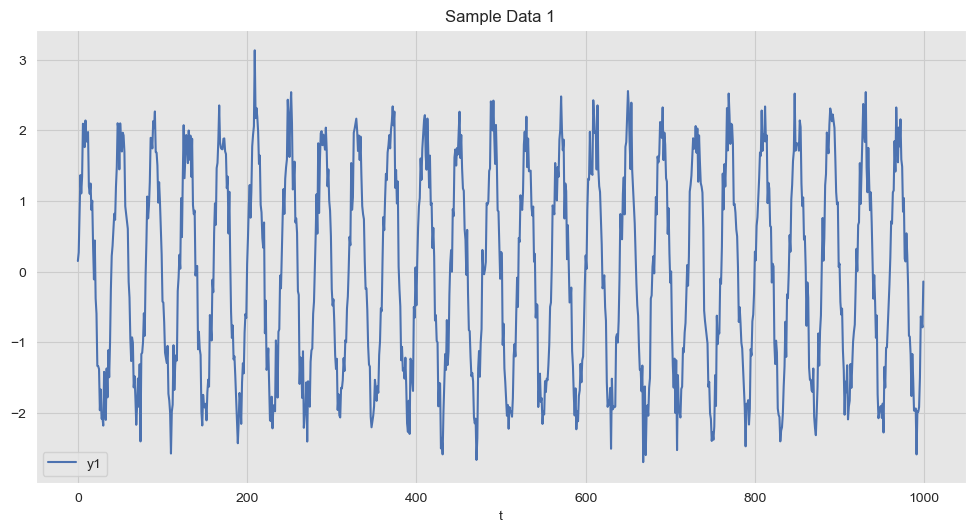

In [4]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label='y1', ax=ax) 
ax.set(title='Sample Data 1', xlabel='t', ylabel='')
ax.legend(loc='lower left');

In [5]:
y = tf.convert_to_tensor(value=data_df['y1'], dtype=dtype)
x = tf.convert_to_tensor(value=data_df['t'], dtype=dtype)

x = tf.reshape(x, [-1, 1])
y = tf.reshape(y, [-1, 1])

prop_train = 0.7
n_train = round(prop_train*n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

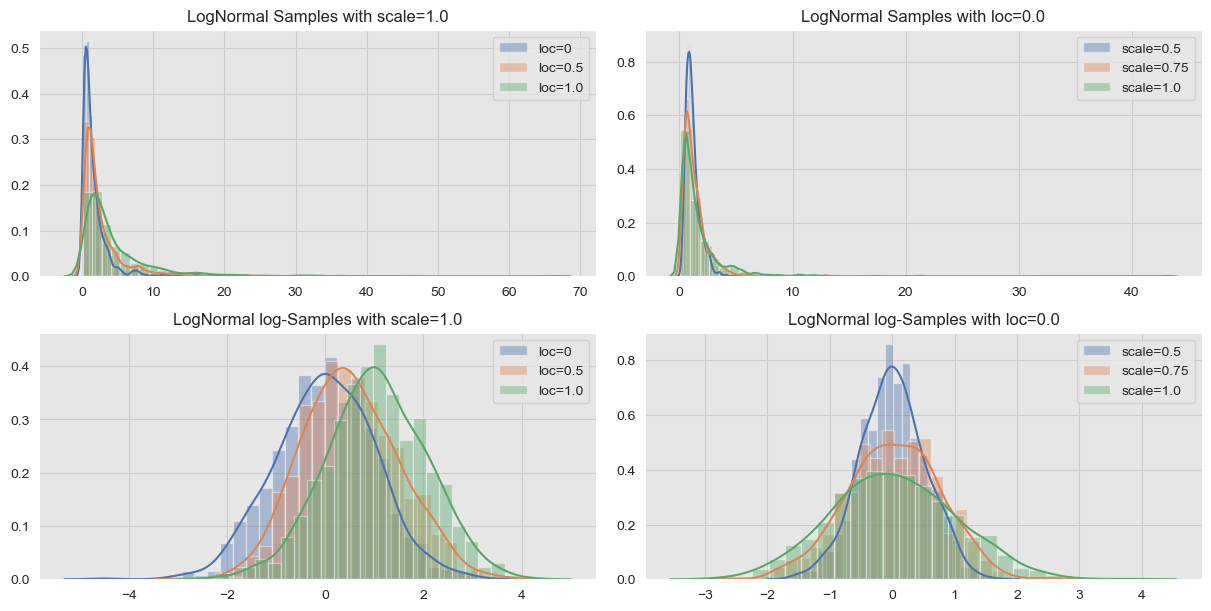

In [119]:
locs = [0, 0.5, 1.0]
scales = [0.5, 0.75, 1.0]

lognormal_samples_1 = tfd.LogNormal(loc=locs, scale=1.0).sample(1000)
log_lognormal_samples_1 = tf.math.log(lognormal_samples_1)
lognormal_samples_2 = tfd.LogNormal(loc=0.0, scale=scales).sample(1000)
log_lognormal_samples_2 = tf.math.log(lognormal_samples_2)

fig, axes = plt.subplots(2, 2, constrained_layout=True)

axes = axes.flatten()

for i, loc in enumerate(locs):
    sns.distplot(a=lognormal_samples_1[:, i], color=sns_c[i], label=f'loc={loc}', ax=axes[0])
    sns.distplot(a=log_lognormal_samples_1[:, i], color=sns_c[i], label=f'loc={loc}', ax=axes[2])
axes[0].legend()
axes[0].set(title='LogNormal Samples with scale=1.0')
axes[2].legend()
axes[2].set(title='LogNormal log-Samples with scale=1.0')

for i, scale in enumerate(scales):
    sns.distplot(a=lognormal_samples_2[:, i], color=sns_c[i], label=f'scale={scale}', ax=axes[1])
    sns.distplot(a=log_lognormal_samples_2[:, i], color=sns_c[i], label=f'scale={scale}', ax=axes[3])
axes[1].legend()
axes[1].set(title='LogNormal Samples with loc=0.0')
axes[3].legend()
axes[3].set(title='LogNormal log-Samples with loc=0.0');


In [151]:
def build_gp_model(amplitude, length_scale, period, observation_noise_variance): 
    # Set Gaussian Process kernel. 
    kernel = tfk.ExpSinSquared(
        amplitude=amplitude,
        length_scale=length_scale, 
        period=period
    )
    # Return Gaussian Process distribution. 
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=x_train,
        mean_fn=None,
        observation_noise_variance=observation_noise_variance
    )


gp_joint_model = tfd.JointDistributionNamed(dict(
    amplitude=tfd.LogNormal(loc=tf.cast(0.0, dtype), scale=tf.cast(1.0, dtype)),
    length_scale=tfd.LogNormal(loc=tf.cast(0.0, dtype), scale=tf.cast(1.0, dtype)),
    period=tfd.LogNormal(loc=tf.cast(4.0, dtype), scale=tf.cast(1.0, dtype)),
    observation_noise_variance=tfd.LogNormal(loc=tf.cast(0.0, dtype), scale=tf.cast(1.0, dtype)),
    observations=build_gp_model
))

In [152]:
tf.random.set_seed(42)

gp_prior_samples = gp_joint_model.sample(20)

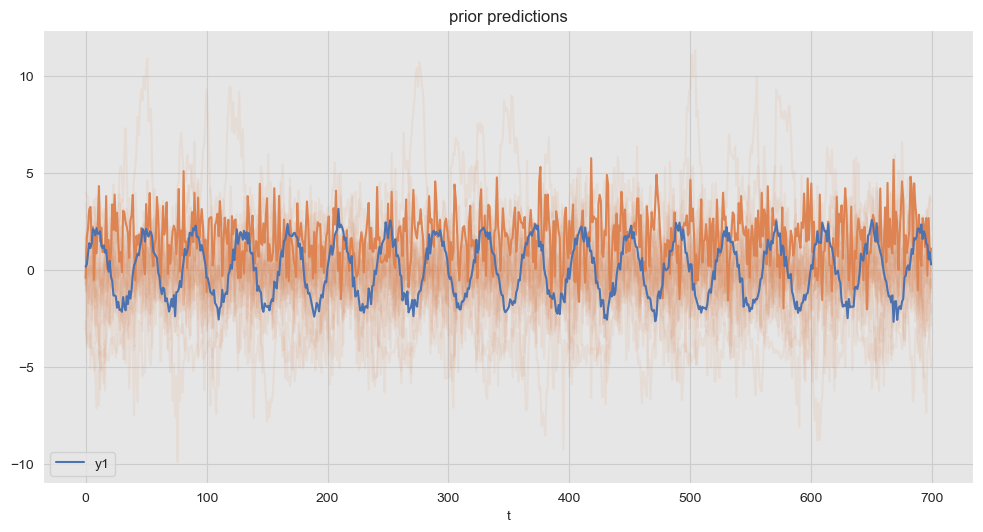

In [153]:
fig, ax = plt.subplots()

for i in range(1, 20):     
    sns.lineplot(
        x=x_train[..., 0].numpy(), 
        y=gp_prior_samples['observations'][i, ].numpy(), 
        color=sns_c[1],
        alpha=0.1,
        ax=ax
    )

sns.lineplot(
    x=x_train[..., 0].numpy(), 
    y=gp_prior_samples['observations'][0, ].numpy(), 
    color=sns_c[1],
    ax=ax
)

sns.lineplot(x=x_train[..., 0], y=y_train[..., 0], color=sns_c[0], label='y1', ax=ax) 
ax.set(title='Sample Data 1', xlabel='t', ylabel='')
ax.legend(loc='lower left');

ax.set(title='prior predictions');

In [157]:
# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, experimental_compile=False)
def target_log_prob_fn(amplitude, length_scale, period, observation_noise_variance):
  return gp_joint_model.log_prob(dict(
      amplitude=amplitude,
      length_scale=length_scale,
      period=period,
      observation_noise_variance=observation_noise_variance,
      observations=y_train[..., 0]
  ))

In [163]:
# Size of each chain.
num_results = int(1e4)
# Burn-in steps.
num_burnin_steps = int(1e3)
# Hamiltonian Monte Carlo transition kernel. 
# I TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=tf.cast(0.1, dtype),
  num_leapfrog_steps=8
  
)
# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)

initial_state = [tf.cast(x, dtype) for x in [1e-10, 1e-10, 4.0, 0.0]]
# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in). 
  # Implements MCMC via repeated TransitionKernel steps.
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state ,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples

In [161]:
run_chain()

InvalidArgumentError:  Input matrix is not invertible.
	 [[{{node mcmc_sample_chain/trace_scan/while/body/_234/smart_for_loop/while/body/_677/simple_step_size_adaptation___init__/_one_step/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/body/_1079/leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/gradients/leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/StatefulPartitionedCall_grad/PartitionedCall/gradients/JointDistributionNamed/log_prob/JointDistributionNamed_log_prob_GaussianProcess/log_prob/JointDistributionNamed_log_prob_GaussianProcess/get_marginal_distribution/Cholesky_grad/triangular_solve/MatrixTriangularSolve}}]] [Op:__inference_run_chain_34607]

Function call stack:
run_chain
